In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import tensorflow as tf
from tensorflow import keras

house_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
house_data = house_data.sample(frac=1).reset_index(drop=True)
train_labels = house_data["SalePrice"].copy()
#LABELS_NORMALISE_SUB = train_labels.mean()
#LABELS_NORMALISE_SCALE = train_labels.std()
#train_labels = train_labels.sub(LABELS_NORMALISE_SUB)
#train_labels = train_labels.div(LABELS_NORMALISE_SCALE)
train_data = house_data.copy()
train_data.drop(columns="SalePrice", inplace=True)
print(f"length of train data: {train_data.shape[0]}\nunique rows in train data: {train_data.drop_duplicates().shape[0]}")
assert "SalePrice" not in train_data.columns


length of train data: 1460
unique rows in train data: 1460


Columns contain mixture of categorical data and numerical data, these will require different preprocessing. We have:
* Numerical data: This needs to be scaled between 0 and 1.
* Categorical data (including the zoning code!): This needs to be one-hot encoded.
* 'Quality' categories: This needs to be converted to an equal numeric range between 0 and 1.

Missing values must also be managed:
* For numerical columns, exclude all NA rows to find the mean, then replace NA with the mean wherever it appears
* For categorical columns, NA will be included as a category
* Neither the training data nor test data contains any nulls (but if they were there then they should be replaced with NA first, then subjected to the same processing.

All these steps must be performed on the training data and validation data separately after splitting them! (wrap in function to take each) otherwise replacement with the mean of the whole dataset would lead to information leakage between train and validation sets.

In [3]:
def quality_preprocess(data):
    lotshapeencode = {"Reg":0, "IR1":1, "IR2":2, "IR3":3}
    data["LotShape"] = data["LotShape"].replace(lotshapeencode)
    landslopeencode = {"Gtl":0, "Mod":1, "Sev":2}
    data["LandSlope"] = data["LandSlope"].replace(landslopeencode)
    qualcondencode = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "NA":0}
    data["ExterQual"] = data["ExterQual"].replace(qualcondencode)
    data["ExterCond"] = data["ExterCond"].replace(qualcondencode)
    data["BsmtQual"] = data["BsmtQual"].replace(qualcondencode)
    data["BsmtCond"] = data["BsmtCond"].replace(qualcondencode)
    exposureencode = {"Gd":3, "Av":2, "Mn":1, "No":0}
    data["BsmtExposure"] = data["BsmtExposure"].replace(exposureencode)
    data["HeatingQC"] = data["HeatingQC"].replace(qualcondencode)
    data["KitchenQual"] = data["KitchenQual"].replace(qualcondencode)
    functionalencode = {"Typ":7, "Min1":6, "Min2":5, "Mod":4, "Maj1":3, "Maj2":2, "Sev":1, "Sal":0}
    data["Functional"] = data["Functional"].replace(functionalencode)
    data["FireplaceQu"] = data["FireplaceQu"].replace(qualcondencode)
    finishencode = {"Fin":2, "RFn":1, "Unf":0}
    data["GarageFinish"] = data["GarageFinish"].replace(finishencode)
    data["GarageQual"] = data["GarageQual"].replace(qualcondencode)
    data["GarageCond"] = data["GarageCond"].replace(qualcondencode)
    poolencode = {"Ex":4, "Gd":3, "TA":2, "Fa":1, "NA":0}
    data["PoolQC"] = data["PoolQC"].replace(poolencode)
    fenceencode = {"GdPrv":4, "MnPrv":3, "GdWo":2, "MnWw":1, "NA":0}
    data["Fence"] = data["Fence"].replace(fenceencode)
    data["DateSold"] = data["YrSold"] + (data["MoSold"] / 12)
    data.drop(columns=["YrSold", "MoSold"])
    return data


Define which columns should be categorical, and which should be numerical

In [4]:
categorical_features = [
    "MSSubClass",
    "MSZoning",
    "Street",
    "Alley",
    "LandContour",
    "Utilities",
    "LotConfig",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "Foundation",
    "BsmtFinType1",
    "BsmtFinType2",
    "Heating",
    "CentralAir",
    "Electrical",
    "GarageType",
    "PavedDrive",
    "MiscFeature",
    "SaleType",
    "SaleCondition"
]

numerical_features = [
    "LotFrontage",
    "LotArea",
    "LotShape",
    "LandSlope",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "HeatingQC",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "KitchenQual",
    "TotRmsAbvGrd",
    "Functional",
    "Fireplaces",
    "FireplaceQu",
    "GarageYrBlt",
    "GarageFinish",
    "GarageCars",
    "GarageArea",
    "GarageQual",
    "GarageCond",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "PoolQC",
    "Fence",
    "MiscVal",
    "DateSold"
]

assert len(categorical_features) + len(numerical_features) == 78

Write preprocess instructions for categorical features, and loop for numerical features

In [5]:
def one_hot_feature(data, feature, featlist):
    if feature in data:
        one_hot = pd.get_dummies(data[feature])
        for feat in featlist:
            if feat not in one_hot.keys():
                one_hot[feat] = 0
        newnames = []
        for feat in featlist:
            newname = feature + '.' + feat
            newnames.append(newname)
        rename_dict = dict(zip(featlist, newnames))
        one_hot = one_hot.rename(columns = rename_dict)
        data = data.drop(columns = feature)
        data = data.join(one_hot)
    return data

def categorical_preprocess(data):
    subclasslist = ["20","30","40","45","50","60","70","75","80","85","90","120","150","160","180","190"]
    data = one_hot_feature(data, "MSSubClass", subclasslist)
    zoninglist = ['A', 'C (all)','FV','I','RH','RL','RP','RM']
    data = one_hot_feature(data, "MSZoning", zoninglist)
    streetlist = ['Grvl','Pave']
    data = one_hot_feature(data, "Street", streetlist)
    alleylist = ['Grvl','Pave','NA']
    data = one_hot_feature(data, "Alley", alleylist)
    contourlist = ['Lvl','Bnk','HLS','Low']
    data = one_hot_feature(data, "LandContour", contourlist)
    utilitieslist = ['AllPub', 'NoSewr', 'NoSeWa', 'ELO']
    data = one_hot_feature(data, "Utilities", utilitieslist)
    lotconfiglist = ['Inside','Corner','CulDSac','FR2','FR3']
    data = one_hot_feature(data, "LotConfig", lotconfiglist)
    neighborhoodlist = [
        'Blmngtn',
        'Blueste',
        'BrDale',
        'BrkSide',
        'ClearCr',
        'CollgCr',
        'Crawfor',
        'Edwards',
        'Gilbert',
        'IDOTRR',
        'MeadowV',
        'Mitchel',
        'Names',
        'NoRidge',
        'NPkVill',
        'NridgHt',
        'NWAmes',
        'OldTown',
        'SWISU',
        'Sawyer',
        'SawyerW',
        'Somerst',
        'StoneBr',
        'Timber',
        'Veenker'
    ]
    data = one_hot_feature(data, "Neighborhood", neighborhoodlist)
    conditionlist = ['Artery','Feedr','Norm','RRNn','RRAn','PosN','PosA','RRNe','RRAe']
    data = one_hot_feature(data, "Condition1", conditionlist)
    data = one_hot_feature(data, "Condition2", conditionlist)
    bldgtypelist = ['1Fam','2FmCon','Duplx','TwnhsE','TwnhsI']
    data = one_hot_feature(data, "BldgType", bldgtypelist)
    housestylelist = ['1Story','1.5Fin','1.5Unf','2Story','2.5Fin','2.5Unf','SFoyer','SLvl']
    data = one_hot_feature(data, "HouseStyle", housestylelist)
    roofstylelist = ['Flat','Gable','Gambrel','Hip','Mansard','Shed']
    data = one_hot_feature(data, "RoofStyle", roofstylelist)
    roofmatllist = ['ClyTile','CompShg','Membran','Metal','Roll','Tar&Grv','WdShake','WdShngl']
    data = one_hot_feature(data, "RoofMatl", roofmatllist)
    exteriorlist = [
        'AsbShng',
        'AsphShn',
        'BrkFace',
        'BrkComm',
        'CBlock',
        'CemntBd',
        'HdBoard',
        'ImStucc',
        'MetalSd',
        'Other',
        'Plywood',
        'PreCast',
        'Stone',
        'Stucco',
        'VinylSd',
        'Wd Sdng',
        'WdShing'
    ]
    data = one_hot_feature(data, "Exterior1st", exteriorlist)
    data = one_hot_feature(data, "Exterior2nd", exteriorlist)
    masvnrtypelist = ['BrkCmn','BrkFace','CBlock','None','Stone']
    data = one_hot_feature(data, "MasVnrType", masvnrtypelist)
    foundationlist = ["BrkTil",'Cblock','PConc','Slab','Stone','Wood']
    data = one_hot_feature(data, "Foundation", foundationlist)
    bsmtfinlist = ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA']
    data = one_hot_feature(data, "BsmtFinType1", bsmtfinlist)
    data = one_hot_feature(data, "BsmtFinType2", bsmtfinlist)
    heatinglist = ['Floor','GasA','GasW','Grav','OthW','Wall']
    data = one_hot_feature(data, "Heating", heatinglist)
    centralairlist = ['N','Y']
    data = one_hot_feature(data, "CentralAir", centralairlist)
    electricallist = ['SBrkr','FuseA','FuseF','FuseP','Mix']
    data = one_hot_feature(data, "Electrical", electricallist)
    garagelist = ['2Types','Attchd','Basement','BuiltIn','CarPort','Detchd','NA']
    data = one_hot_feature(data, "GarageType", garagelist)
    paveddrivelist = ['Y','N','P']
    data = one_hot_feature(data, "PavedDrive", paveddrivelist)
    misclist = ['Elev','Gar2','Othr','Shed','TenC','NA']
    data = one_hot_feature(data, "MiscFeature", misclist)
    saletypelist = ['WD','CWD','VWD','New','COD','Con','ConLw','ConLI','ConLD','Oth']
    data = one_hot_feature(data, "SaleType", saletypelist)
    saleconditionlist = ['Normal','Abnorml','AdjLand','Alloca','Family','Partial']
    data = one_hot_feature(data, "SaleCondition", saleconditionlist)
    return data

def normalise_preprocess(data):
    for feature in numerical_features:
        data[feature] = data[feature].replace({"NA":pd.NA})
        mean = data[feature].mean()
        data[feature] = data[feature].fillna(mean)
        stddev = data[feature].std()
        data[feature] = data[feature].sub(mean)
        data[feature] = data[feature].div(stddev)
    data = data.astype("float64")
    return data



Features must be tested for relevance: numerical data must be tested by pearson coefficient (pandas df.corr(method='pearson')), ordinal categorical data (which will be numbers) tested by spearman's rank coefficient (pandas df.corr(method='spearman'))

non-ordered categorical data will be tested by stdev of means / mean of stdevs of the sale price for each category in the field (unless i can find a better clustering metric on the internet)
if that doesn't work, then after one-hot encoding i will just find the stddev of the sales inside the category and divide the stddev of the whole set by that to drop individual one-hot encodes

In [6]:

house_data = quality_preprocess(house_data)

catcoeffs = {}
for feature in categorical_features:
    categories = house_data[feature].unique()
    catlist = categories.tolist()
    catmeans = []
    catdevs = []
    for category in catlist:
        cluster_data = house_data[[feature, "SalePrice"]].loc[house_data[feature] == category]
        catmeans.append(cluster_data["SalePrice"].mean())
        catdevs.append(cluster_data["SalePrice"].std())
    devofmeans = pd.DataFrame(catmeans).std()
    meanofdevs = pd.DataFrame(catdevs).mean()
    catcoeffs[feature] = devofmeans[0] / meanofdevs[0]

ordinal_features = [
    "LotShape",
    "LandSlope",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "HeatingQC",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "KitchenQual",
    "TotRmsAbvGrd",
    "Functional",
    "Fireplaces",
    "FireplaceQu",
    "GarageYrBlt",
    "GarageFinish",
    "GarageCars",
    "GarageQual",
    "GarageCond",
    "Fence",
    "MiscVal",
    "PoolQC"
]

non_ordinal_features = []

for feature in numerical_features:
    if feature not in ordinal_features:
        non_ordinal_features.append(feature)

for feature in ordinal_features:
    assert feature not in categorical_features

numcoeffs = {}
for feature in numerical_features:
    if feature in ordinal_features:
        numcoeffs[feature] = abs(house_data[feature].corr(house_data["SalePrice"], method="spearman"))
    else:
        numcoeffs[feature] = abs(house_data[feature].corr(house_data["SalePrice"], method="pearson"))
    print(f"{feature}, {numcoeffs[feature]}")

LotFrontage, 0.35179909657067787
LotArea, 0.2638433538714056
LotShape, 0.3210553314019312
LandSlope, 0.05031026015605547
OverallQual, 0.8098285862017292
OverallCond, 0.12932494660061317
YearBuilt, 0.6526815462850586
YearRemodAdd, 0.5711589780582343
MasVnrArea, 0.47749304709571644
ExterQual, 0.6840137963904298
ExterCond, 0.01168188943505925
BsmtQual, 0.6643925141791525
BsmtCond, 0.19640152640384195
BsmtExposure, 0.3048188693877465
BsmtFinSF1, 0.3864198062421532
BsmtFinSF2, 0.011378121450215141
BsmtUnfSF, 0.2144791055469689
TotalBsmtSF, 0.6135805515591957
HeatingQC, 0.4913919065603799
1stFlrSF, 0.6058521846919145
2ndFlrSF, 0.31933380283206797
LowQualFinSF, 0.02560613000067954
GrLivArea, 0.7086244776126522
BsmtFullBath, 0.22512486719612368
BsmtHalfBath, 0.012188876310787316
FullBath, 0.6359570562496957
HalfBath, 0.34300754918568294
BedroomAbvGr, 0.23490671789027862
KitchenAbvGr, 0.1648257549850205
KitchenQual, 0.6728485475386915
TotRmsAbvGrd, 0.532585935116993
Functional, 0.13548919114874

Remove features with weak correlation if needed

PoolQC and PoolArea destabilise the model: this is because they are numerical but are mostly zeros/NaNs so the normalisation process doesn't work properly if either the train set or validation set only includes zeros/NaNs. filter these out by checking for a large modal value (which because they're continuous must be zero or NaN.

In [7]:
CATTHRESHOLD = 0.1
NUMTHRESHOLD = 0.1

trash_feats = ["Id"]
for feature in categorical_features:
    if catcoeffs[feature] < CATTHRESHOLD:
        trash_feats.append(feature)
for feature in numerical_features:
    if numcoeffs[feature] < NUMTHRESHOLD or house_data[feature].value_counts(normalize=True, dropna=False).iloc[0] > 0.99:
        trash_feats.append(feature)
for feature in trash_feats:
    if feature in numerical_features:
        numerical_features.remove(feature)
train_data = quality_preprocess(train_data)
train_data.drop(columns = trash_feats, inplace=True)
train_data = categorical_preprocess(train_data)

print(f"Removed the following features: {trash_feats}\n")

print(f"length of train data: {train_data.shape[0]}\nunique rows in train data: {train_data.drop_duplicates().shape[0]}")

Removed the following features: ['Id', 'LandSlope', 'ExterCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'DateSold']

length of train data: 1460
unique rows in train data: 1460


Some rows are no longer unique if features are aggressively removed, this is ok though.
Prepare the model

In [8]:
LEARNING_RATE = 0.001

def build_model():
    model = keras.Sequential([
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1)
    ])
    opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=opt, loss="mse", metrics=["mae"])
    return model


Set up k-fold validation and train

2022-07-27 20:51:01.154224: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-27 20:51:01.273077: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
31/31 [==============================] - 1s 12ms/step - loss: 38442921984.0000 - mae: 179477.7656 - val_loss: 38194397184.0000 - val_mae: 178120.9062
Epoch 2/500
31/31 [==============================] - 0s 4ms/step - loss: 36415623168.0000 - mae: 173750.0000 - val_loss: 34623516672.0000 - val_mae: 167813.3125
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 30684481536.0000 - mae: 156333.0781 - val_loss: 26253664256.0000 - val_mae: 140768.8281
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 20322457600.0000 - mae: 118325.1797 - val_loss: 14461263872.0000 - val_mae: 91421.0469
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 9953817600.0000 - mae: 68961.9453 - val_loss: 7162056192.0000 - val_mae: 57272.0742
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 6256488448.0000 - mae: 54768.6914 - val_loss: 6293025280.0000 - val_mae: 58422.4609
Epoch 7/500
31/31 [=======================

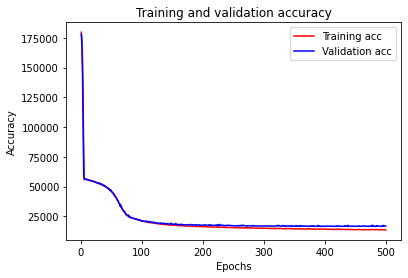

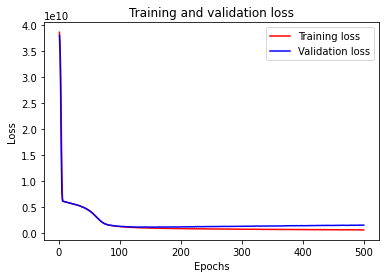

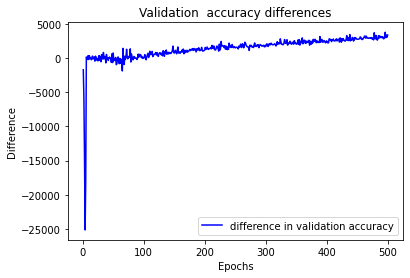

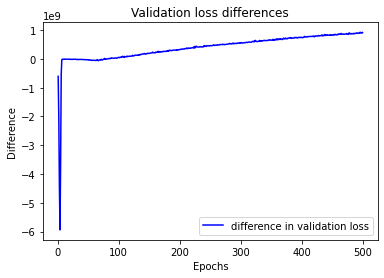

In [9]:
EPOCHS = 500
FOLDS = 3
FOLD_SIZE = len(train_data) // FOLDS
val_accs = []
total_val_acc = []
val_losses = []
total_val_loss = []
train_accs = []
total_train_acc = []
train_losses = []
total_train_loss = []
acc_diffs = []
total_acc_diffs = []
loss_diffs = []
total_loss_diffs = []

for k in range(FOLDS):
    #train_data = train_data.sample(frac=1).reset_index(drop=True)
    val_data = train_data.iloc[k * FOLD_SIZE: (k+1) * FOLD_SIZE].copy()
    val_labels = train_labels.iloc[k * FOLD_SIZE: (k+1) * FOLD_SIZE].copy()
    partial_train_data = pd.concat([train_data.iloc[: k * FOLD_SIZE] , train_data.iloc[(k+1) * FOLD_SIZE:]])
    partial_train_labels = pd.concat([train_labels.iloc[: k * FOLD_SIZE] , train_labels.iloc[(k+1) * FOLD_SIZE:]])
    
    assert "SalePrice" not in partial_train_data.columns
    
    val_data = normalise_preprocess(val_data)
    partial_train_data = normalise_preprocess(partial_train_data)

    model = build_model()

    history = model.fit(partial_train_data,
                        partial_train_labels,
                        batch_size=32,
                        epochs=EPOCHS,
                        validation_data=(val_data, val_labels),
                        verbose=1,
                        )

    history_dict = history.history
    
    train_losses.append(history_dict['loss'])
    val_losses.append(history_dict['val_loss'])
    train_accs.append(history_dict['mae'])
    val_accs.append(history_dict['val_mae'])
    acc_diffs.append([a - b for a,b in zip(history_dict['val_mae'], history_dict['mae'])])
    loss_diffs.append([a - b for a,b in zip(history_dict['val_loss'], history_dict['loss'])])

def metrics_average(metric, total):
    for e in range(len(metric[0])):
        to_sum = 0
        for k in range(FOLDS):
            to_sum += metric[k][e]
        total_value = to_sum / FOLDS
        total.append(total_value)

metrics_average(train_losses, total_train_loss)
metrics_average(val_losses, total_val_loss)
metrics_average(train_accs, total_train_acc)
metrics_average(val_accs, total_val_acc)
metrics_average(acc_diffs, total_acc_diffs)
metrics_average(loss_diffs, total_loss_diffs)

epochs = range(1, len(total_train_acc) + 1)

plt.plot(epochs, total_train_acc, 'r', label='Training acc')
plt.plot(epochs, total_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.plot(epochs, total_train_loss, 'r', label='Training loss')
plt.plot(epochs, total_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, total_acc_diffs, 'b', label='difference in validation accuracy')
plt.title('Validation  accuracy differences')
plt.xlabel('Epochs')
plt.ylabel('Difference')
plt.legend()

plt.show()

plt.plot(epochs, total_loss_diffs, 'b', label='difference in validation loss')
plt.title('Validation loss differences')
plt.xlabel('Epochs')
plt.ylabel('Difference')
plt.legend()

plt.show()

In [10]:
#train_data = normalise_preprocess(train_data)
#print(train_data.iloc[[1400]])
#test1 = model.predict(train_data.iloc[[1400]])
#truth1 = train_labels.iloc[[1400]]

#print(f"model predicted {test1}, real answer {truth1}")

prep final model for predictions

In [11]:
EPOCHS = 500

final_model = build_model()

final_train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
final_train_data = final_train_data.sample(frac=1).reset_index(drop=True)
final_train_labels = final_train_data["SalePrice"]
final_train_data.drop(columns="SalePrice", inplace=True)
final_train_data = quality_preprocess(final_train_data)
final_train_data = final_train_data.drop(columns = trash_feats)
final_train_data = categorical_preprocess(final_train_data)
final_train_data = normalise_preprocess(final_train_data)

final_history = final_model.fit(final_train_data,
                    final_train_labels,
                    batch_size=32,
                    epochs=EPOCHS,
                    verbose=1,
                    )

test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
test_data = test_data.sample(frac=1).reset_index(drop=True)
test_ids = test_data["Id"]
test_data = quality_preprocess(test_data)
test_data = test_data.drop(columns = trash_feats)
test_data = categorical_preprocess(test_data)
test_data = normalise_preprocess(test_data)

print(f"extra columns: {test_data.columns.symmetric_difference(final_train_data.columns)}")
test_data.drop(columns = test_data.columns.symmetric_difference(final_train_data.columns), inplace=True)
print(f"extra columns: {test_data.columns.symmetric_difference(final_train_data.columns)}")

test_outputs = final_model.predict(np.array(test_data))
convergecompare = final_model.predict(np.array(final_train_data.iloc[[1000]]))
print(f"test prediction: {convergecompare}")
print(f"first few predicted prices: {test_outputs[:5]}")

Epoch 1/500
46/46 [==============================] - 0s 3ms/step - loss: 37945036800.0000 - mae: 177870.7031
Epoch 2/500
46/46 [==============================] - 0s 2ms/step - loss: 31298125824.0000 - mae: 157455.2812
Epoch 3/500
46/46 [==============================] - 0s 3ms/step - loss: 15779698688.0000 - mae: 97477.2734
Epoch 4/500
46/46 [==============================] - 0s 2ms/step - loss: 6583592960.0000 - mae: 55993.6289
Epoch 5/500
46/46 [==============================] - 0s 2ms/step - loss: 6113640960.0000 - mae: 56782.3906
Epoch 6/500
46/46 [==============================] - 0s 3ms/step - loss: 6054497280.0000 - mae: 56088.9922
Epoch 7/500
46/46 [==============================] - 0s 2ms/step - loss: 6002926080.0000 - mae: 55746.6289
Epoch 8/500
46/46 [==============================] - 0s 2ms/step - loss: 5952734720.0000 - mae: 55709.3242
Epoch 9/500
46/46 [==============================] - 0s 2ms/step - loss: 5906055680.0000 - mae: 55393.8242
Epoch 10/500
46/46 [============

save predictions to file

In [12]:
submission = zip(test_ids, test_outputs)

sub_frame = pd.DataFrame(data=submission, columns=["Id", "SalePrice"])
sub_frame["SalePrice"] = sub_frame["SalePrice"].astype("float64")
sub_frame.to_csv("/kaggle/working/submit7.csv", columns=["Id","SalePrice"], index=False)